(114690, 19)


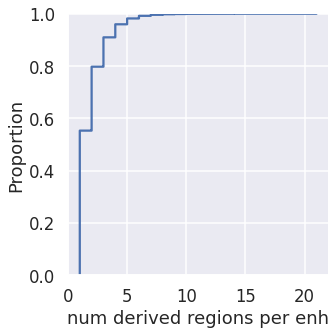

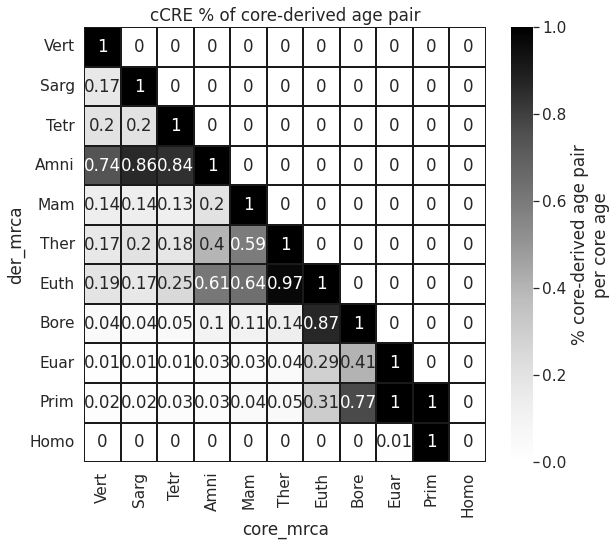

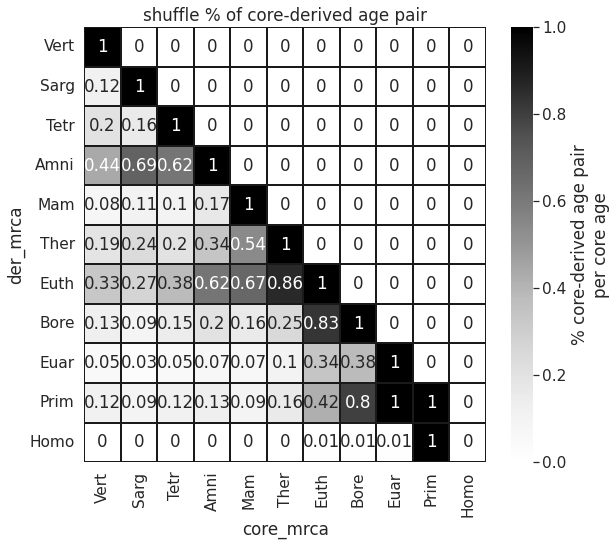

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


202103

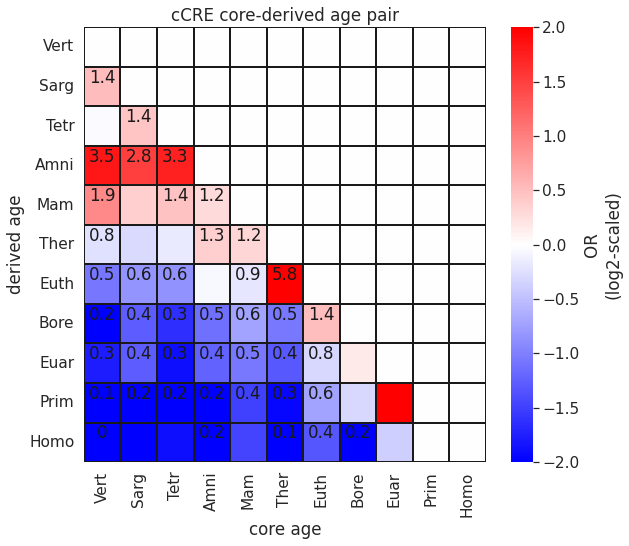

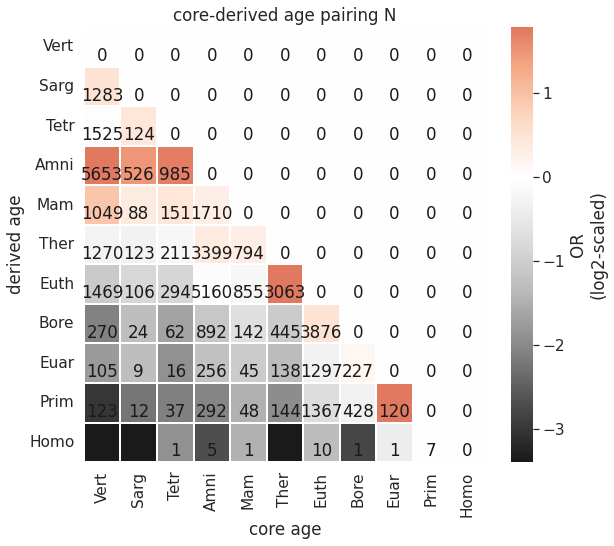

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels
import statsmodels.api as sm

import subprocess
#%%

CL = "HepG2"
GENOME_BUILD = "hg38"

cCREPATH = f"/dors/capra_lab/projects/enhancer_ages/encode/data/ELS_combined_{CL}/ages/"
cCREFILE = f"syn_breaks_ELS_combined_{CL}_ages.bed"
cCRE = os.path.join(cCREPATH, cCREFILE)

#cCRE_TFBS_ONLY = f"{cCREPATH}enh_tfbs_only.txt"

SHUFPATH = f"/dors/capra_lab/projects/enhancer_ages/encode/data/ELS_combined_{CL}/shuffle/ages/"
SHUFFILE = f"syn_breaks_shuf-ELS_combined_{CL}.bed"
SHUFF = os.path.join(SHUFPATH, SHUFFILE)


RE = f"/dors/capra_lab/projects/enhancer_ages/landscape/results/cCRE/{CL}/"


#%%


def add_arch_labels(df):

    df["arch"] = "complex_core"

    df.loc[df.core_remodeling ==0, "arch"] = "simple"
    df.loc[df.core ==0, "arch"] = "complex_derived"

    return df



# get all the complex primate enhancers and evaluate which ones actually
# have human derievd regions. The rest will be reassigned as simple enhancers.
def reEval_PrimComplex(enh):

    # get all the complex enhancers w/ primate core ages
    prComEnhID = enh.loc[(enh.core ==1) &
    (enh.core_remodeling ==1) &
    (enh.taxon2.str.contains("Primate"))]["enh_id"].unique()

    # get all the complex enhancer ids where there is a real human derived sequence
    pr_complex = enh.loc[(enh.enh_id.isin(prComEnhID)) &
    (enh.core_remodeling == 1) &
    (enh.core ==0) &
    (enh.mrca ==0),
    ]["enh_id"]


    # i'm going to reassign any primate complex enhancer
    # where derived regions are from other primates
    # get the set of primate complex enhancers w/ primate derived sequences
    # and rename them as simple enhancers
    pr_simple = set(prComEnhID) - set(pr_complex)

    # reassign core and core remodeling columns
    enh.loc[enh.enh_id.isin(pr_simple), "core"] = 1
    enh.loc[enh.enh_id.isin(pr_simple), "core_remodeling"] = 0
    return enh


def format_syndf(enh_age_file, build):

    syn_cols = ["chr_syn", "start_syn", "end_syn",
    "enh_id",
    "chr", "start", "end",
    "seg_index", "core_remodeling", "core",
    "mrca",]

    syn = pd.read_csv(enh_age_file, sep ='\t', header = None, names = syn_cols)

    syn["syn_id"] = syn.chr_syn + ":" + syn.start_syn.map(str) + "-" + syn.end_syn.map(str)

    syn["syn_len"] = syn.end_syn - syn.start_syn
    syn["enh_len"] = syn.end - syn.start


    # age and taxon file
    syn_gen_bkgd_file = f"/dors/capra_lab/projects/enhancer_ages/{build}_syn_gen_bkgd.tsv"
    syn_gen_bkgd= pd.read_csv(syn_gen_bkgd_file, sep = '\t') # read the file
    syn_gen_bkgd[["mrca", "mrca_2"]] = syn_gen_bkgd[["mrca", "mrca_2"]].round(3) # round the ages

    syn_gen_bkgd = syn_gen_bkgd[["mrca", "taxon", "mrca_2", "taxon2"]] # whittle down the df
    syn["mrca"] = syn["mrca"].round(3) # round the ages

    syn = pd.merge(syn, syn_gen_bkgd, how = "left", on = "mrca")
    syn = reEval_PrimComplex(syn)
    labeled_syn = add_arch_labels(syn) # add architecture labels

    return labeled_syn


def get_core_der_frac(enh):
    cor_dict = {}
    mrca_lst =  enh.mrca_2.unique()
    for mrca_2 in mrca_lst:
        if mrca_2 != 0.00:
            # get the set of core enhancer ages
            core = set(enh.loc[(enh["core"] ==1)
            & (enh["core_remodeling"] == 1)
            & (enh["mrca_2"] == mrca_2), "enh_id"])

            collection_results = {} # collect all the n
            # per derived age
            for mrca_2_der in mrca_lst:

                # get the enhancer ids with the core age and with derived age
                der = set(enh.loc[(enh["enh_id"].isin(core)) & (enh['mrca_2']== mrca_2_der), "enh_id"])

                # quantify % of cores that have der region of mrca_2_der age
                percent_overlap = len(der)/len(core)

                results = pd.DataFrame({
                "core_mrca":[mrca_2],
                "der_mrca":[mrca_2_der],
                "core_enh_count":[len(core)],
                "der_enh_count":[len(der)],
                "core_der_overlap":[percent_overlap]})

                collection_results[mrca_2_der] = results
            all_results = pd.concat(collection_results.values())

            cor_dict[mrca_2] = all_results


    corr = pd.concat(cor_dict.values())
    return corr


def calc_OR(corr, shuf_corr):

    collection_dict = {}

    # iterate through core and derived ages
    for core_mrca_2 in corr.core_mrca.unique():

        for der_mrca_2 in corr.der_mrca.unique():
            # only test core /derived pairs according to definition that
            # derived sequences are younger than core sequences
            #print(core_mrca_2, "-", der_mrca_2)
            if der_mrca_2 < core_mrca_2 and core_mrca_2 != 0.0:

                comparison_name = f"core-{core_mrca_2}_der-{der_mrca_2}"
                total_core = corr.loc[corr["core_mrca"] == core_mrca_2, "core_enh_count"].iloc[0]
                total_core_shuf = shuf_corr.loc[shuf_corr["core_mrca"] == core_mrca_2, "core_enh_count"].iloc[0]

                a = corr.loc[(corr["core_mrca"] == core_mrca_2)&(corr["der_mrca"] == der_mrca_2), "der_enh_count"].iloc[0] # the cores that overlap derived regions of an age
                b = total_core - a # the cores that do not overlap derived regions of an age
                c = shuf_corr.loc[(shuf_corr["core_mrca"] == core_mrca_2)&(shuf_corr["der_mrca"] == der_mrca_2), "der_enh_count"].iloc[0] # the shuffled cores that overlap derived regions of an age
                d = total_core_shuf - c # the shuffled cores that do not overlap derived regions of an age

                obs = [[a,b], [c,d]]


                OR, P = stats.fisher_exact(obs)
                table = sm.stats.Table2x2(obs) # get confidence interval
                odds_ci = table.oddsratio_confint()
                newdf = pd.DataFrame({"comparison_name":comparison_name,
                                      "a":obs[0][0], "b":obs[0][1],
                                      "c":obs[1][0], "d":obs[1][1],
                                      "OR":[OR], "P":[P],
                                      "ci_lower" :[odds_ci[0]],
                                      "ci_upper" :[odds_ci[1]],
                                      "core_mrca": [core_mrca_2],
                                      "der_mrca": [der_mrca_2]
                                    })
                collection_dict[comparison_name] = newdf
                #if P<0.05:
                #    print(comparison_name, obs, round(OR, 2), round(P, 4))

    # do an FDR correction
    fdr_corrected = fdr_correction(collection_dict)
    # calculate log10p for enrichment/depletion
    fdr_corrected["-log10p"] = np.log10(fdr_corrected["FDR_P"]) *(-1)


    # get list of ORs and treat 0, inf odds ratio values
    ors = list(fdr_corrected.OR)
    max_or = max(i for i in ors if i < np.inf)
    min_or = min(i for i in ors if i > 0)
    # handle cases where OR is absolutely 0
    fdr_corrected.loc[fdr_corrected["OR"] == 0, "OR"] = 0.01

    # handle cases where OR is inf
    fdr_corrected.loc[fdr_corrected["OR"] == np.inf, "OR"] = max_or

    # calculate log2 OR
    fdr_corrected["log2"] = np.log2(fdr_corrected["OR"])



    return fdr_corrected


def fdr_correction(collection_dict):

    df = pd.concat(collection_dict.values())

    pvals = df["P"]

    df["reject_null"], df["FDR_P"] = statsmodels.stats.multitest.fdrcorrection(pvals, alpha=0.05)

    return df


def add_zeros_to_table(table):


    table[0] = 0
    table = table.sort_index()
    if 0.867 not in list(table.index):
        table.loc[0.957] = 0

    table = table.replace(-np.Inf, np.nan) # clean up and fill negative infinitis
    table = table.fillna(0)
    table = table.round(2)
    table = table[[ 0.19 , 0.867, 0.756, 0.606, 0.425, 0.497, 0.167, 0.656, 0.144,
       0.146, 0.]]

    return table


def plot_frac(table, name, x, y, inv ):

    xlabs = ["Homo","Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg",  "Vert"]

    if inv == 1: # if you invert axis, make sure everything gets configured
        xlabs = xlabs[::-1] # if you want oldest ages on top.
        table = table.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)


        mask = np.tril(np.ones_like(table, dtype=np.bool))
        outf = f"{RE}{name}_core_der_age_fraction_heatmap_inv.pdf"

    else:
        outf = f"{RE}{name}_core_der_age_fraction_heatmap.pdf"
        mask = np.triu(np.ones_like(table, dtype=np.bool))

    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(figsize=(9,8))

    sns.heatmap(table,
    #mask =mask,
    annot = True,
    linewidths = 1,
    linecolor = "k",
    cmap = "Greys",
    cbar_kws={'label': '% core-derived age pair\nper core age'},
    ax = ax
    )

    ax.set_xticklabels(xlabs)
    ax.set_yticklabels(xlabs)
    ax.set(title = f"{name} % of core-derived age pair",
    ylabel = y,
    xlabel = x)

    plt.savefig(outf, bbox_inches = "tight")
    plt.show()


def pivot_table(x, y, df, val):
    table = pd.pivot(df, index = x, columns = y, values = val)
    table = add_zeros_to_table(table) # add zeros
    table = table.iloc[::-1] # invert

    return table

def plot_OR(OR_log2_table, OR_log10_annot, OR_table, inv):
    xlabs = ["Homo","Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"]
    if inv == 1: # if you invert axis, make sure everything gets configured
        xlabs = xlabs[::-1] # if you want oldest ages on top.

        OR_log2_table = OR_log2_table.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)
        OR_log10_annot = OR_log10_annot.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)
        OR_table = OR_table.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)

        mask = np.tril(np.ones_like(OR_table, dtype=np.bool))
        outf = f"{RE}OR_core_der_age_heatmap_annot-log2_inv.pdf"

    else:
        outf = f"{RE}OR_core_der_age_heatmap_annot-log2.pdf"
        mask = np.triu(np.ones_like(OR_log2_table, dtype=np.bool))

    fig, ax = plt.subplots(figsize=(9,8))
    sns.set(font_scale=1.4)

    # plot log2 OR (color) and annotate with log10p asterisks
    OR_log2_table
    sns.heatmap(OR_log2_table,
    cmap = "bwr",
    vmin=-2, vmax=2,
    center = 0,
    linewidths = 1,
    linecolor = 'k',
    annot = False,
    annot_kws={ "color": "k", "ha": 'left',"va": 'top'},
    fmt = '.1d',
    cbar_kws={'label': 'OR\n(log2-scaled)'},


    )

    # plot log2 annotation
    sns.heatmap(OR_table,
    mask = OR_log10_annot == False,
    annot = True,
    annot_kws={"color": "k", "ha": 'center',"va": 'bottom'},
    alpha = 0,
    cbar = False,
    ax = ax
    )


    ax.set(
    title = "cCRE core-derived age pair",
    xlabel = "core age",
    ylabel = "derived age"
    )

    ax.set_xticklabels(xlabs)
    ax.set_yticklabels(xlabs)

    plt.savefig(outf, bbox_inches = "tight")

def plot_count_table(OR_log2_table, a_table, RE):
    fig, ax = plt.subplots(figsize=(9,8))
    sns.set(font_scale=1.4)
    # plot log2 OR
    OR_log2_table = OR_log2_table.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)
    sns.heatmap(OR_log2_table,
    annot = False,
    cmap = "RdGy_r",
    cbar_kws={'label': 'OR\n(log2-scaled)'},
    ax = ax,
    center = 0,
    robust = True,
    linewidths = 1,
    )
    a_table  = a_table.sort_index(ascending =False).sort_index(ascending  =False, axis = 1)
    # plot n annotation
    a_table = a_table.fillna(0).astype(int)
    sns.heatmap(a_table,
    #mask = a_table<1,
    annot = True, fmt = 'd',
    annot_kws={"color": "k", "ha": 'center',"va": 'top'},
    alpha = 0,
    cbar = False,
    ax = ax
    )

    ax.set(
    title = "core-derived age pairing N",
    xlabel = "core age",
    ylabel = "derived age"
    )
    xlabs = ["Homo","Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg",  "Vert"]#xlabs = xlabs[]
    ax.set_xticklabels(xlabs[::-1])
    ax.set_yticklabels(xlabs[::-1])
    outf = f"{RE}OR_core_der_age_heatmap_annot-n.pdf"
    plt.savefig(outf, bbox_inches = "tight")

def DerCore_Ratio(enh):
    cdratio = enh.loc[enh["core_remodeling"] ==1].groupby(['enh_id','core'])["arch"].count().reset_index()
    cdratio.columns = ["enh_id", "core", "num derived regions per enh"]
    data = cdratio.loc[cdratio["core"] ==0].describe()
    sns.set("talk")
    g = sns.displot(cdratio.loc[cdratio["core"] ==0, "num derived regions per enh"],
    kind="ecdf")
    outf = f"{RE}cdf_n_der.pdf"
    plt.savefig(outf, bbox_inches = "tight")

    return data

#%%


enh = format_syndf(cCRE, GENOME_BUILD)
enh["id"] = "cCRE"
print(enh.shape)
#%%

DerCore_Ratio(enh)
"""
core	arch
count	27789.0	27789.000000
mean	0.0	1.811184
std	0.0	1.234378
min	0.0	1.000000
25%	0.0	1.000000
50%	0.0	1.000000
75%	0.0	2.000000
max	0.0	21.000000
"""
#%%
# calculate fractions of der/cor combos per core age
corr = get_core_der_frac(enh)

# pivot corr into datatable w/ fraction overlap as value
x,y =  "der_mrca","core_mrca",
corr_table = corr.pivot(index = x, columns = y, values = "core_der_overlap")
corr_table = add_zeros_to_table(corr_table) # add human column to make matrix square

# plot the fraction of core derived pairs taht overlap
name = "cCRE"
yplot = corr_table.index.name
xplot = corr_table.columns.name
corr_table.iloc[::-1]

plot_frac(corr_table.iloc[::-1], name, xplot, yplot, 1)

#%%


shuf = format_syndf(SHUFF, GENOME_BUILD)
shuf["id"] = "SHUFFLE"
shuf.head()
shuf_corr = get_core_der_frac(shuf)
shuf_corr_table = shuf_corr.pivot(index = x, columns = y, values = "core_der_overlap")
shuf_corr_table = add_zeros_to_table(shuf_corr_table)

# plot the fraction of core derived pairs taht overlap
name = "shuffle"

yplot = shuf_corr_table.index.name
xplot = shuf_corr_table.columns.name
shuf_corr_table.iloc[::-1]

plot_frac(shuf_corr_table.iloc[::-1], name, xplot, yplot, 1)

#%%

# calculate the odds ratio of observing
fdr_OR = calc_OR(corr, shuf_corr)
fdr_OR
fdr_OR.head()
#fdr_OR.loc[fdr_OR.comparison_name == "core-0.867_der-0.190"]
fdr_OR.loc[fdr_OR.comparison_name == "core-0.867_der-0.0"]
#fdr_OR = fdr_OR.reset_index()

#%%
# pivot table for OR
x,y =  "der_mrca","core_mrca",

OR_table = pivot_table(x, y, fdr_OR,"OR")
OR_table = OR_table.round(1)
OR_table
# pivot table for log2OR (color )
OR_log2_table = pivot_table(x, y, fdr_OR, "log2")


# pivot table for log10p
OR_log10_annot = pivot_table(x, y, fdr_OR, "reject_null")
OR_log10_annot.replace([-0, 0], False, inplace=True) # replace all the other values with no value

a_table = pivot_table(x, y, fdr_OR,"a")


x,y =  "der_mrca","core_mrca"

#%% plot OR


plot_OR(OR_log2_table, OR_log10_annot, OR_table, 1)



#%% Count table

plot_count_table(OR_log2_table, a_table, RE)
#%%
len(enh.loc[enh["core_remodeling"]==1].enh_id.unique())# 10942

len(shuf.loc[shuf["core_remodeling"]==1].enh_id.unique()) # 1126876

#%%

